In [ ]:
!apt-get update
!apt-get install -y octave liboctave-dev
!pip install math-verify openpyxl

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:4 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,798 kB]
Get:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy/main amd64 Packages [33.2 kB]
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://securit

In [ ]:
import subprocess
import tempfile
import os
import shutil

class OctaveExecutionError(Exception): pass
class OctaveTimeoutError(Exception): pass

class OctaveCodeExecutor:
    def __init__(self, timeout: int = 10, octave_cmd: str = 'octave', max_output_size: int = 10000):
        self.timeout = timeout
        self.octave_cmd = octave_cmd
        self.max_output_size = max_output_size

        # ✅ Verificar que el binario esté disponible
        if shutil.which(self.octave_cmd) is None:
            raise FileNotFoundError(
                f"❌ El binario '{self.octave_cmd}' no se encontró en el sistema.\n"
                f"🛠 Asegúrate de instalar Octave con:\n"
                f"!apt-get update && apt-get install -y octave"
            )

    def _write_temp_file(self, code: str) -> str:
        with tempfile.NamedTemporaryFile(mode='w', suffix='.m', delete=False) as f:
            f.write(code)
            return f.name

    def execute_with_timeout(self, code: str) -> tuple[str | None, str | None]:
        file_path = self._write_temp_file(code)
        try:
            result = subprocess.run(
                [self.octave_cmd, "--quiet", "--no-gui", "--eval", f"run('{file_path}')"],
                stdout=subprocess.PIPE,
                stderr=subprocess.PIPE,
                timeout=self.timeout,
                text=True,
                check=False
            )
            stdout = result.stdout[:self.max_output_size].strip()
            stderr = result.stderr.strip()
            return stdout, stderr if stderr else None
        except subprocess.TimeoutExpired:
            raise OctaveTimeoutError("⏱️ Tiempo de ejecución excedido para el código Octave.")
        finally:
            os.remove(file_path)


In [ ]:
import pandas as pd
from pathlib import Path

# Ruta base
base_dir = Path("/content/drive/MyDrive/tesis/resultados_consolidados")

# Recorrer todos los archivos .csv en la carpeta y subcarpetas
csv_files = list(base_dir.rglob("*.csv"))

print(f"🔍 Se encontraron {len(csv_files)} archivos .csv.")

for csv_path in csv_files:
    try:
        df = pd.read_csv(csv_path)
        df_short = df.head(400)

        # Sobrescribir el archivo original (puedes cambiar esto si quieres guardar una copia)
        df_short.to_csv(csv_path, index=False)
        print(f"✅ Archivo truncado a 400 filas: {csv_path}")
    except Exception as e:
        print(f"❌ Error al procesar {csv_path}: {e}")


In [ ]:
import pandas as pd
from pathlib import Path
import re
from tqdm import tqdm

# Expresión regular para extraer bloques Octave
_CODE_RE = re.compile(r"```(?:octave|m)?[\s\r\n]*(.*?)```", re.DOTALL | re.I)

def extract_octave_code(text: str) -> str:
    m = _CODE_RE.search(str(text))
    return m.group(1).strip() if m else str(text).strip()

def process_all_csvs_extract_code(
    root_dir: str,
    input_col: str = "model_output",
    output_col: str = "octave_code",
    condition_col: str = "is_octave_resolvable"
):
    """
    Extrae código Octave condicionalmente desde múltiples archivos CSV
    y muestra resumen por archivo.
    """
    root = Path(root_dir)
    csv_files = list(root.rglob("*.csv"))
    resumen_global = []

    for csv_file in tqdm(csv_files, desc="Procesando CSVs"):
        try:
            df = pd.read_csv(csv_file)

            if input_col not in df.columns or condition_col not in df.columns:
                print(f"⚠️ Falta '{input_col}' o '{condition_col}' en {csv_file.name}")
                continue

            total = len(df)
            resolvables = df[condition_col] == True

            df[output_col] = [
                extract_octave_code(row[input_col]) if row[condition_col] == True else ""
                for _, row in df.iterrows()
            ]

            extraidos = df[output_col].astype(str).str.strip().replace("", pd.NA).notna().sum()

            df.to_csv(csv_file, index=False)

            resumen_global.append({
                "archivo": csv_file.name,
                "ruta": str(csv_file),
                "total_filas": total,
                "resolvables": resolvables.sum(),
                "codigo_extraido": extraidos
            })

        except Exception as e:
            print(f"❌ Error procesando {csv_file.name}: {e}")

    resumen_df = pd.DataFrame(resumen_global)
    return resumen_df

resumen = process_all_csvs_extract_code("/content/drive/MyDrive/tesis/resultados_consolidados")
from IPython.display import display
display(resumen)



In [ ]:
import pandas as pd
from pathlib import Path
import re
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# Expresión regular para extraer bloques Octave
_CODE_RE = re.compile(r"```(?:octave|m)?[\s\r\n]*(.*?)```", re.DOTALL | re.I)

def extract_octave_code(text: str) -> str:
    m = _CODE_RE.search(str(text))
    return m.group(1).strip() if m else ""

def display_fixed_width_block(title: str, content: str, language: str = ""):
    html = f"""
    <div style="max-width: 900px; overflow-x: auto; border: 1px solid #ccc; padding: 10px; margin-bottom: 10px; font-family: monospace; background: #f9f9f9;">
        <b>{title}</b>
        <pre><code class="{language}">{content}</code></pre>
    </div>
    """
    display(HTML(html))

# Ruta base
base_path = "/content/drive/MyDrive/tesis/resultados_consolidados"
csv_files = list(Path(base_path).rglob("*.csv"))
print(f"📁 Se encontraron {len(csv_files)} archivos CSV para inspección visual.")

# Función principal
def inspeccionar_csv(csv_index=0, start_row=0, end_row=None):
    path = csv_files[csv_index]
    print(f"\n📂 Archivo: {path}")
    df = pd.read_csv(path)

    if "model_output" not in df.columns or "octave_code" not in df.columns:
        print("❌ El archivo no tiene las columnas requeridas.")
        return

    total_rows = len(df)
    end_row = total_rows if end_row is None else min(end_row, total_rows)
    state = {"index": start_row}

    def mostrar_fila():
        clear_output(wait=True)
        i = state["index"]
        print(f"\n🔢 Fila {i + 1} de {total_rows}")
        display_fixed_width_block("🧾 model_output", str(df.at[i, "model_output"]))
        display_fixed_width_block("🎯 octave_code extraído", str(df.at[i, "octave_code"]), language="octave")
        display(widgets.HBox([btn_continuar, btn_terminar]))

    def continuar_clicked(b):
        state["index"] += 1
        if state["index"] < end_row:
            mostrar_fila()
        else:
            clear_output()
            print("✅ Revisión finalizada.")

    def terminar_clicked(b):
        clear_output()
        print("⛔ Revisión interrumpida por el usuario.")

    btn_continuar = widgets.Button(description="✅ Continuar", button_style="success")
    btn_terminar = widgets.Button(description="⛔ Terminar", button_style="danger")
    btn_continuar.on_click(continuar_clicked)
    btn_terminar.on_click(terminar_clicked)

    mostrar_fila()


📁 Se encontraron 48 archivos CSV para inspección visual.


In [ ]:
inspeccionar_csv(csv_index=1, start_row=0, end_row=60)


⛔ Revisión interrumpida por el usuario.


In [ ]:
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
import re
import logging
from math_verify import parse, verify

logger = logging.getLogger("octave_validator")

_NUM_RE = re.compile(r"[-+]?\d*\.?\d+(?:[eE][+-]?\d+)?[ij]?", re.I)

def extract_numbers(text: str) -> set[str]:
    return {m.group(0).lower() for m in _NUM_RE.finditer(str(text))}

def validate_existing_octave_code(
    csv_path: str,
    executor,
    batch_size: int = 8,
    overwrite: bool = False,
    output_dir: str = None
) -> str:
    """
    Ejecuta y valida el código Octave ya extraído (columna 'octave_code') en un CSV,
    solo si 'is_octave_resolvable' es True.

    Args:
        csv_path (str): Ruta al CSV.
        executor: Instancia de OctaveCodeExecutor.
        batch_size (int): No se usa aquí pero se mantiene por compatibilidad.
        overwrite (bool): Si False, se salta filas ya evaluadas.
        output_dir (str): Ruta para guardar una copia del CSV actualizado (opcional).

    Returns:
        str: Ruta al archivo CSV actualizado.
    """
    df = pd.read_csv(csv_path)

    required_cols = ["octave_code", "answer", "is_octave_resolvable"]
    for col in required_cols + ["execution_output", "execution_error", "is_correct"]:
        if col not in df.columns:
            df[col] = None

    for i in tqdm(range(len(df)), desc="Validando código Octave existente"):
        if not df.at[i, "is_octave_resolvable"]:
            continue
        if not overwrite and pd.notna(df.at[i, "is_correct"]):
            continue

        code = str(df.at[i, "octave_code"]).strip()
        gold = str(df.at[i, "answer"]).strip()

        if not code:
            df.at[i, "execution_output"] = None
            df.at[i, "execution_error"] = "Empty code"
            df.at[i, "is_correct"] = False
            continue

        try:
            stdout, stderr = executor.execute_with_timeout(code)
            df.at[i, "execution_output"] = stdout
            df.at[i, "execution_error"] = stderr

            correct = False
            if stderr is None and stdout:
                try:
                    correct = verify(parse(gold), parse(stdout))
                except Exception:
                    correct = False

                if not correct:
                    out_nums = extract_numbers(stdout)
                    gold_nums = extract_numbers(gold)
                    correct = bool(out_nums) and out_nums.issubset(gold_nums)

            df.at[i, "is_correct"] = correct

        except Exception as e:
            df.at[i, "execution_output"] = None
            df.at[i, "execution_error"] = str(e)
            df.at[i, "is_correct"] = False

    df.to_csv(csv_path, index=False)

    if output_dir:
        fecha = datetime.now().strftime("%Y%m%d")
        outfile = Path(output_dir) / f"{fecha}_{Path(csv_path).stem}_validated.csv"
        df.to_csv(outfile, index=False)
        logger.info(f"📁 Validación guardada en: {outfile}")
        return str(outfile)

    return str(csv_path)


In [ ]:
def validate_all_csvs_with_existing_octave_code(
    root_dir: str,
    executor,
    overwrite: bool = False,
    output_dir: str = None
) -> pd.DataFrame:
    """
    Valida todos los archivos CSV en un directorio usando código ya extraído
    en la columna 'octave_code', y condicional en 'is_octave_resolvable'.

    Args:
        root_dir (str): Carpeta raíz con archivos .csv.
        executor: Instancia de OctaveCodeExecutor.
        overwrite (bool): Si False, salta filas ya validadas.
        output_dir (str): Carpeta para guardar copias validadas (opcional).

    Returns:
        pd.DataFrame: Resumen con cantidad de correctos por archivo.
    """
    from pathlib import Path
    from tqdm import tqdm

    root = Path(root_dir)
    csv_files = list(root.rglob("*.csv"))
    resumen = []

    for csv_file in tqdm(csv_files, desc="Validando archivos CSV"):
        try:
            validated_path = validate_existing_octave_code(
                csv_path=str(csv_file),
                executor=executor,
                overwrite=overwrite,
                output_dir=output_dir
            )
            df = pd.read_csv(validated_path)
            total = len(df)
            resolvables = df["is_octave_resolvable"].sum()
            ejecutados = df["execution_output"].notna().sum()
            correctos = df["is_correct"].sum()

            resumen.append({
                "archivo": csv_file.name,
                "ruta": str(csv_file),
                "total_filas": total,
                "resolvables": resolvables,
                "ejecutados": ejecutados,
                "correctos": correctos
            })

        except Exception as e:
            resumen.append({
                "archivo": csv_file.name,
                "ruta": str(csv_file),
                "error": str(e)
            })

    return pd.DataFrame(resumen)


In [ ]:
executor = OctaveCodeExecutor(timeout=10)

resumen = validate_all_csvs_with_existing_octave_code(
    root_dir="/content/drive/MyDrive/tesis/resultados_consolidados",
    executor=executor,
    overwrite=False,
    output_dir="/content/drive/MyDrive/tesis/resultados_validados"
)
from IPython.display import display
display(resumen)


In [ ]:
import pandas as pd
from pathlib import Path
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets

# Carpeta raíz
base_path = "/content/drive/MyDrive/tesis/resultados_consolidados"
csv_files = list(Path(base_path).rglob("*.csv"))
print(f"📁 Se encontraron {len(csv_files)} archivos CSV.")

def display_block(title: str, content: str, style: str = ""):
    html = f"""
    <div style="max-width: 900px; overflow-x: auto; border: 1px solid #ccc;
                padding: 10px; margin-bottom: 10px; font-family: monospace;
                background: #f9f9f9; {style}">
        <b>{title}</b>
        <pre>{content}</pre>
    </div>
    """
    display(HTML(html))

def revisar_resultados_incorrectos(csv_index=0):
    path = csv_files[csv_index]
    print(f"\n📂 Archivo: {path}")
    df = pd.read_csv(path)

    required = ["is_correct", "is_octave_resolvable", "execution_output", "answer", "execution_error", "question"]
    if not all(col in df.columns for col in required):
        print("❌ El archivo no contiene todas las columnas necesarias.")
        return

    # Filtrar los incorrectos y resolubles
    posibles = df[(df["is_correct"] == False) & (df["is_octave_resolvable"] == True)].copy()

    # Separar con y sin errores de ejecución
    sin_error = posibles[df["execution_error"].isnull() | (df["execution_error"].astype(str).str.strip() == "")]
    con_error = posibles[~(df["execution_error"].isnull() | (df["execution_error"].astype(str).str.strip() == ""))]

    if con_error.shape[0] > 0:
        print(f"⚠️ Se omitieron {len(con_error)} casos con errores de ejecución. Índices:")
        print(con_error.index.tolist())

    if sin_error.empty:
        print("✅ No hay respuestas incorrectas resolubles y ejecutadas sin errores para revisar.")
        return

    errores = sin_error
    idx_list = errores.index.tolist()
    state = {"i": 0}

    def mostrar_fila():
        clear_output(wait=True)
        idx = idx_list[state["i"]]
        print(f"🔢 Revisión {state['i']+1} de {len(idx_list)}  |  Fila original {idx}")

        display_block("📌 Problema (question)", str(df.at[idx, "question"]))
        display_block("🧾 Respuesta esperada (answer)", str(df.at[idx, "answer"]))
        display_block("🖥️ Resultado del código (execution_output)", str(df.at[idx, "execution_output"]))

        display(widgets.HBox([btn_marcar_correcto, btn_siguiente, btn_terminar]))

    def marcar_correcto_clicked(b):
        idx = idx_list[state["i"]]
        df.at[idx, "is_correct"] = True
        avanzar()

    def avanzar():
        state["i"] += 1
        if state["i"] >= len(idx_list):
            clear_output()
            print("✅ Revisión completada.")
            df.to_csv(path, index=False)
        else:
            mostrar_fila()

    def siguiente_clicked(b):
        avanzar()

    def terminar_clicked(b):
        clear_output()
        print("⛔ Revisión interrumpida. Cambios guardados.")
        df.to_csv(path, index=False)

    # Botones
    btn_marcar_correcto = widgets.Button(description="✅ Marcar como correcta", button_style="success")
    btn_siguiente = widgets.Button(description="⏭️ Siguiente", button_style="info")
    btn_terminar = widgets.Button(description="⛔ Terminar", button_style="danger")

    btn_marcar_correcto.on_click(marcar_correcto_clicked)
    btn_siguiente.on_click(siguiente_clicked)
    btn_terminar.on_click(terminar_clicked)

    mostrar_fila()


📁 Se encontraron 48 archivos CSV.


In [ ]:
revisar_resultados_incorrectos(csv_index=47)

✅ Revisión completada.


In [4]:
import os
import pandas as pd
from IPython.display import display

# ─── 1. Ruta base ────────────────────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"

# ─── 2. Cargar archivos CSV ──────────────────────────────
all_dfs = []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                df['model'] = df.get('model', ['unknown'])[0]
                df['strategy'] = df.get('strategy', ['unknown'])[0]
                df['dataset'] = df.get('dataset', ['unknown'])[0]
                all_dfs.append(df)
            except Exception as e:
                print(f"❌ Error cargando {path}: {e}")

if not all_dfs:
    raise RuntimeError("No se encontraron CSVs válidos en la ruta especificada")

full_df = pd.concat(all_dfs, ignore_index=True)

# ─── 3. Agrupamiento y cálculo de métricas ───────────────
summary = []
grouped = full_df.groupby(['model', 'strategy'])

for (model, strategy), group in grouped:
    total_all = len(group)

    avg_time = group['inference_time'].mean() if 'inference_time' in group.columns else None
    correct_total = group['is_correct'].sum()
    accuracy_total = correct_total / total_all if total_all > 0 else None

    # Filtrar resolubles
    resolubles = group[group['is_octave_resolvable'] == True]
    total_res = len(resolubles)

    # Identificar errores de ejecución
    has_error = resolubles['execution_error'].notna() & (resolubles['execution_error'].astype(str).str.strip() != "")
    num_errors = has_error.sum()
    ejecutados_ok = len(resolubles[~has_error])  # <-- Aquí la métrica clave

    summary.append({
        'Model': model,
        'Strategy': strategy,
        'Total Examples': total_all,
        'Resolvable Examples': total_res,
        'Executed OK': ejecutados_ok,
        'Num Errors': int(num_errors),
        'Accuracy (total)': round(accuracy_total, 3) if accuracy_total is not None else None,
        'Avg. Inference Time (s)': round(avg_time, 2) if avg_time is not None else None
    })

# ─── 4. Mostrar ranking por códigos ejecutados ───────────
summary_df = pd.DataFrame(summary).sort_values(by='Executed OK', ascending=False)

print("🏆 Ranking de combinaciones modelo–estrategia por cantidad de códigos ejecutados correctamente:")
display(summary_df[['Model', 'Strategy', 'Resolvable Examples', 'Executed OK', 'Num Errors']])


🏆 Ranking de combinaciones modelo–estrategia por cantidad de códigos ejecutados correctamente:


,Model,Strategy,Resolvable Examples,Executed OK,Num Errors
4,mathstral-7b,cot,1195,867,328
5,mathstral-7b,few_shots,1194,835,359
7,mathstral-7b,zero_shot,1194,825,369
6,mathstral-7b,rag,1139,786,353
12,qwen2-math-7b-instruct,cot,1134,771,363
14,qwen2-math-7b-instruct,rag,1080,732,348
15,qwen2-math-7b-instruct,zero_shot,1082,715,367
10,mistral-7b-instruct,rag,1094,697,397
13,qwen2-math-7b-instruct,few_shots,1084,690,394
11,mistral-7b-instruct,zero_shot,1068,679,389




## ⚙️ 1. **Códigos Ejecutados sin Error**

Esta métrica refleja **robustez práctica del modelo**: no solo resolver correctamente, sino generar código **que realmente se ejecuta sin fallos**.

| 🥇 Top 5 combinaciones con más códigos ejecutados exitosamente |
| -------------------------------------------------------------- |
| `mathstral - cot` → **867**                                    |
| `mathstral - few_shots` → **835**                              |
| `mathstral - zero_shot` → **825**                              |
| `mathstral - rag` → **786**                                    |
| `qwen2 - cot` → **771**                                        |

### 💡 Observaciones:

* **Mathstral-7B** domina este ranking en todas las estrategias, demostrando **gran robustez de ejecución**.
* **Qwen2-Cot** es el único de otro modelo que se acerca a este grupo superior.
* La estrategia **CoT** parece ser la más efectiva en cuanto a ejecución sin errores, especialmente con Mathstral.

---

| 🔻 Combinaciones con menor cantidad de ejecuciones exitosas |
| ----------------------------------------------------------- |
| `deepseek - zero_shot` → **222**                            |
| `deepseek - cot` → **317**                                  |
| `deepseek - rag` → **446**                                  |
| `deepseek - few_shots` → **455**                            |

### 🧠 Análisis:

* **DeepSeek-Math-7B** genera significativamente menos códigos que se ejecutan correctamente, a pesar de tener relativamente pocos errores.
* Esto podría indicar **limitaciones en calidad del código generado** (aunque sintácticamente correcto, es semánticamente inválido).
* **Mistral** se comporta de forma intermedia: más robusto que DeepSeek, pero aún por debajo de Qwen2 y Mathstral.

---

## ✅ Conclusión específica para ejecución

| Aspecto                                      | Mejor Opción           | Comentario                                      |
| -------------------------------------------- | ---------------------- | ----------------------------------------------- |
| 🛠️ **Mayor cantidad de códigos ejecutados** | `Mathstral + CoT`      | Extremadamente robusto en ejecución             |
| 📊 **Mejor ejecución fuera de Mathstral**    | `Qwen2 + CoT`          | Alternativa sólida con buen rendimiento general |
| ⚠️ **Peor en ejecución**                     | `DeepSeek + Zero-Shot` | Bajo número de ejecuciones exitosas             |




In [ ]:
import os
import pandas as pd
from IPython.display import display

# ─── 1. Configurar ruta base ──────────────────────────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"

# ─── 2. Cargar todos los archivos CSV ─────────────────────────────────────
all_dfs = []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                df['model'] = df.get('model', ['unknown'])[0]
                df['strategy'] = df.get('strategy', ['unknown'])[0]
                df['dataset'] = df.get('dataset', ['unknown'])[0]
                all_dfs.append(df)
            except Exception as e:
                print(f"❌ Error cargando {path}: {e}")

if not all_dfs:
    raise RuntimeError("No se encontraron CSVs válidos en la ruta especificada")

full_df = pd.concat(all_dfs, ignore_index=True)

# ─── 3. Agrupamiento y cálculo de métricas ───────────────────────────────
summary = []
grouped = full_df.groupby(['model', 'strategy'])

for (model, strategy), group in grouped:
    total_all = len(group)

    avg_time = group['inference_time'].mean() if 'inference_time' in group.columns else None
    correct_total = group['is_correct'].sum()
    accuracy_total = correct_total / total_all if total_all > 0 else None

    # Filtrar solo resolubles
    resolubles = group[group['is_octave_resolvable'] == True]
    total_res = len(resolubles)

    # Separar errores de ejecución
    has_error = resolubles['execution_error'].notna() & (resolubles['execution_error'].astype(str).str.strip() != "")
    num_errors = has_error.sum()
    sin_error = resolubles[~has_error]

    correct = sin_error['is_correct'].sum()
    incorrect = len(sin_error) - correct
    accuracy_ok = correct / len(sin_error) if len(sin_error) > 0 else None

    summary.append({
        'Model': model,
        'Strategy': strategy,
        'Total Examples': total_all,
        'Resolvable Examples': total_res,
        'Num Errors': int(num_errors),
        'Correct (no errors)': int(correct),
        'Incorrect (no errors)': int(incorrect),
        'Accuracy (no errors)': round(accuracy_ok, 3) if accuracy_ok is not None else None,
        'Accuracy (total)': round(accuracy_total, 3) if accuracy_total is not None else None,
        'Avg. Inference Time (s)': round(avg_time, 2) if avg_time is not None else None
    })

# ─── 4. Mostrar resultados ────────────────────────────────────────────────
summary_df = pd.DataFrame(summary).sort_values(by='Accuracy (no errors)', ascending=False)
display(summary_df)


,Model,Strategy,Total Examples,Resolvable Examples,Num Errors,Correct (no errors),Incorrect (no errors),Accuracy (no errors),Accuracy (total),Avg. Inference Time (s)
15,qwen2-math-7b-instruct,zero_shot,1200,1082,367,607,108,0.849,0.506,51.86
12,qwen2-math-7b-instruct,cot,1200,1134,363,646,125,0.838,0.538,36.85
14,qwen2-math-7b-instruct,rag,1200,1080,348,608,124,0.831,0.507,53.49
4,mathstral-7b,cot,1200,1195,328,712,155,0.821,0.593,30.41
13,qwen2-math-7b-instruct,few_shots,1200,1084,394,563,127,0.816,0.469,54.67
0,deepseek-math-7b,cot,1200,732,415,252,65,0.795,0.213,21.95
3,deepseek-math-7b,zero_shot,1200,546,324,174,48,0.784,0.148,26.91
7,mathstral-7b,zero_shot,1200,1194,369,615,210,0.745,0.512,31.57
6,mathstral-7b,rag,1200,1139,353,574,212,0.730,0.478,30.35
2,deepseek-math-7b,rag,1200,664,218,318,128,0.713,0.265,28.15



## 🔍 1. **Evaluación Primaria: Accuracy (no errors)**

Este es el nuevo indicador principal porque representa:

> **Correctitud de respuestas sobre problemas que sí se pueden resolver y cuyo código no falló.**

| 🥇 Top 5 combinaciones          |
| ------------------------------- |
| `qwen2 - zero_shot` → **0.849** |
| `qwen2 - cot` → **0.838**       |
| `qwen2 - rag` → **0.831**       |
| `mathstral - cot` → **0.821**   |
| `qwen2 - few_shots` → **0.816** |

### ✅ Mejores combinaciones **sin usar CoT**:

| 🔝 Sin CoT                          |
| ----------------------------------- |
| `qwen2 - zero_shot` → **0.849**     |
| `qwen2 - rag` → **0.831**           |
| `qwen2 - few_shots` → **0.816**     |
| `deepseek - cot` → **0.795**        |
| `deepseek - zero_shot` → **0.784**  |
| `mathstral - zero_shot` → **0.745** |
| `mathstral - rag` → **0.730**       |

### 🧠 Observaciones:

* **Qwen2-math-7b-instruct** es el modelo más preciso *en todos los settings*, lo que valida su consistencia.
* **Mathstral-7b (cot)** logra precisión comparable a Qwen2, pero solo bajo estrategia CoT.
* **Deepseek** y **Mathstral** ofrecen buenas alternativas sin CoT, especialmente bajo estrategias `zero_shot` y `rag`.

---
## 🕒 3. **Tiempo de Inferencia modelo-estrategia**

| 🚀 Más rápido                   |
| ------------------------------- |
| `deepseek - cot` → **21.95 s**  |
| `mathstral - rag` → **30.35 s** |
| `mathstral - cot` → **30.41 s** |

| 🐢 Más lento                      |
| --------------------------------- |
| `qwen2 - few_shots` → **54.67 s** |
| `qwen2 - rag` → **53.49 s**       |
| `qwen2 - zero_shot` → **51.86 s** |

### 💬 Análisis:

* Hay una compensación clara entre **precisión y velocidad**.
* Modelos más robustos (Qwen2) implican mayor coste de cómputo.
* Deepseek y Mathstral son más ligeros pero menos efectivos.

---

## ✅ Conclusión General

| Aspecto                      | Mejor Opción                        | Comentario                                   |
| ---------------------------- | ----------------------------------- | -------------------------------------------- |
| 🔍 **Precisión sin errores** | `Qwen2 + Zero-Shot`                 | Muy alto y consistente                       |
| 📊 **Precisión total**       | `Mathstral + Cot`, `Qwen2 + Cot`    | Ambas opciones buenas                        |
| ⚠️ **Menos errores**         | `Deepseek + Rag`                    | Genera pocos errores pero menos correctos    |
| 🕒 **Más rápido**            | `Deepseek + Cot`                    | Buena opción si velocidad importa            |
| 🧠 **Mejor balance global**  | `Qwen2 + Cot` o `Qwen2 + Zero-Shot` | Fuerte en todas las métricas salvo ejecución |


In [ ]:
import os
import pandas as pd
import numpy as np
from scipy.stats import chi2
from statsmodels.stats.contingency_tables import cochrans_q


# ─── 2. Ruta base ───────────────────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"

# ─── 3. Cargar todos los CSVs ───────────────────────────
all_dfs = []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                df["model"] = df.get("model", ["unknown"])[0]
                df["strategy"] = df.get("strategy", ["unknown"])[0]
                df["id"] = df.index
                if {"is_correct", "is_octave_resolvable", "execution_error"}.issubset(df.columns):
                    all_dfs.append(df)
            except Exception as e:
                print(f"⚠️ Error cargando {path}: {e}")

if not all_dfs:
    raise RuntimeError("❌ No se encontraron CSVs válidos en la ruta especificada.")

# ─── 4. Unir los datasets ──────────────────────────────
full_df = pd.concat(all_dfs, ignore_index=True)

# ─── 5. Filtrar problemas válidos ──────────────────────
valid_df = full_df[
    (full_df["is_octave_resolvable"] == True)
    & (full_df["execution_error"].isnull() | (full_df["execution_error"].astype(str).str.strip() == ""))
]

# ─── 6. Crear matriz binaria de resultados ─────────────
pivot_df = valid_df.pivot_table(
    index="id",
    columns=["model", "strategy"],
    values="is_correct"
)

pivot_df = pivot_df.dropna()  # mantener solo los ejemplos presentes en todos los experimentos
binary_matrix = pivot_df.astype(int).values

# ─── 7. Aplicar Cochran's Q Test ───────────────────────
q_result = cochrans_q(binary_matrix)
print(f"📊 Cochran's Q Statistic: {q_result.statistic:.4f}")
print(f"📉 p-value: {q_result.pvalue:.6f}")

# ─── 8. Interpretación ─────────────────────────────────
alpha = 0.05
if q_result.pvalue < alpha:
    print("✅ Hay diferencias significativas entre las estrategias/modelos. Procede con McNemar Test.")
else:
    print("⚠️ No hay diferencias significativas entre los modelos. McNemar podría no ser necesario.")


📊 Cochran's Q Statistic: 70.3524
📉 p-value: 0.000000
✅ Hay diferencias significativas entre las estrategias/modelos. Procede con McNemar Test.


### 📌 ¿Qué mide Cochran's Q Test?

Cochran’s Q Test evalúa si **tres o más métodos de clasificación binaria (como predicción correcta o incorrecta)** tienen **diferencias significativas en sus rendimientos** sobre los **mismos ítems (problemas)**.

En este caso:

* Cada “tratamiento” es una combinación `modelo|estrategia`.
* Cada ítem es un problema de matemáticas.
* La variable binaria es `is_correct` (1 si se resolvió correctamente, 0 si no).

---

### ⚠️ ¿Por qué el p-value es 0.000000?

Esto ocurre cuando:

* **La estadística Q obtenida es muy alta**, lo que indica que **al menos un modelo-estrategia tiene un comportamiento muy distinto de los demás**.
* El número de problemas compartidos por todas las configuraciones es grande (lo cual aumenta la potencia del test).
* Las proporciones de aciertos difieren claramente entre combinaciones.

El resultado indica que **la hipótesis nula** (todos los métodos tienen el mismo rendimiento) **se rechaza con altísima confianza**.

---

### 🔬 Implicaciones

* Se justifica **con fuerza estadística** seguir adelante con comparaciones por pares (como el test de **McNemar**).
* También puede sugerir que hay **modelos o estrategias claramente inferiores o superiores**, lo cual debe reflejarse en el ranking posterior.



In [ ]:
import os
import pandas as pd
import numpy as np
from itertools import combinations
from scipy.stats import chi2, binomtest
from IPython.display import display

# ─── 1. Ruta base ───────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"

# ─── 2. Cargar CSVs ─────────────────────────
all_dfs = []
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            path = os.path.join(root, file)
            try:
                df = pd.read_csv(path)
                df["model"] = df.get("model", ["unknown"])[0]
                df["strategy"] = df.get("strategy", ["unknown"])[0]
                df["id"] = df.index  # asegurar un identificador único
                if {"is_correct", "is_octave_resolvable", "execution_error"}.issubset(df.columns):
                    all_dfs.append(df)
            except Exception as e:
                print(f"⚠️ Error cargando {path}: {e}")

if not all_dfs:
    raise RuntimeError("❌ No se encontraron CSVs válidos en la ruta especificada.")

# ─── 3. Concatenar en único DataFrame ───────
full_df = pd.concat(all_dfs, ignore_index=True)

# ─── 4. Filtrar solo ejemplos resolubles sin errores de ejecución ────────
valid_df = full_df[
    (full_df["is_octave_resolvable"] == True)
    & (full_df["execution_error"].isnull() | (full_df["execution_error"].str.strip() == ""))
]

# ─── 5. Crear diccionario de (modelo|estrategia) a dict[id → is_correct] ─────
results_dict = {}
for (model, strategy), group in valid_df.groupby(["model", "strategy"]):
    key = f"{model}|{strategy}"
    group = group.dropna(subset=["is_correct"])
    results_dict[key] = dict(zip(group["id"], group["is_correct"].astype(int)))

# ─── 6. McNemar Test entre todos los pares ──────────────────────────────────
mcnemar_results = []
pairs = list(combinations(results_dict.items(), 2))

for (key1, res1), (key2, res2) in pairs:
    common_ids = set(res1) & set(res2)
    if not common_ids:
        continue

    a = sum(res1[i] == 1 and res2[i] == 0 for i in common_ids)
    b = sum(res1[i] == 0 and res2[i] == 1 for i in common_ids)

    if a + b == 0:
        continue

    # McNemar exacto (binomial)
    p = binomtest(min(a, b), n=a + b, p=0.5).pvalue
    stat = (abs(a - b) - 1) ** 2 / (a + b)

    mcnemar_results.append({
        "model_strategy_A": key1,
        "model_strategy_B": key2,
        "n": len(common_ids),
        "mcnemar_statistic": round(stat, 4),
        "mcnemar_p_value": round(p, 6),
    })

# ─── 7. Mostrar resultados McNemar ordenados por significancia ──────────────
mcnemar_df = pd.DataFrame(mcnemar_results).sort_values(by="mcnemar_p_value")


# ─── 8. Determinar el mejor par: el que gana más comparaciones significativas ─────
significance_level = 0.05
win_counter = {}

for row in mcnemar_results:
    a, b = row["model_strategy_A"], row["model_strategy_B"]
    p = row["mcnemar_p_value"]
    if p < significance_level:
        if row["mcnemar_statistic"] > 0:  # gana A
            win_counter[a] = win_counter.get(a, 0) + 1
        else:  # gana B
            win_counter[b] = win_counter.get(b, 0) + 1

ranking_df = pd.DataFrame(list(win_counter.items()), columns=["model_strategy", "significant_wins"])
ranking_df = ranking_df.sort_values(by="significant_wins", ascending=False)
print("📊 McNemar Test Results (pares de modelo|estrategia):")
display(mcnemar_df)
print("🏆 Ranking por número de comparaciones ganadas (McNemar p < 0.05):")
display(ranking_df)




📊 McNemar Test Results (pares de modelo|estrategia):


,model_strategy_A,model_strategy_B,n,mcnemar_statistic,mcnemar_p_value
8,deepseek-math-7b|cot,mistral-7b-instruct|few_shots,226,31.2111,0.000000
20,deepseek-math-7b|few_shots,mathstral-7b|zero_shot,309,30.4466,0.000000
27,deepseek-math-7b|few_shots,qwen2-math-7b-instruct|rag,288,29.6569,0.000000
60,mathstral-7b|cot,mistral-7b-instruct|zero_shot,380,47.5092,0.000000
49,deepseek-math-7b|zero_shot,mistral-7b-instruct|zero_shot,172,32.4675,0.000000
...,...,...,...,...,...
2,deepseek-math-7b|cot,deepseek-math-7b|zero_shot,114,0.0263,0.871415
62,mathstral-7b|cot,qwen2-math-7b-instruct|few_shots,374,0.0082,0.927911
31,deepseek-math-7b|rag,mathstral-7b|few_shots,300,0.0000,1.000000
51,deepseek-math-7b|zero_shot,qwen2-math-7b-instruct|few_shots,168,0.0000,1.000000


🏆 Ranking por número de comparaciones ganadas (McNemar p < 0.05):


,model_strategy,significant_wins
1,deepseek-math-7b|few_shots,11
5,mathstral-7b|few_shots,10
2,deepseek-math-7b|rag,9
4,mathstral-7b|cot,7
0,deepseek-math-7b|cot,6
10,mistral-7b-instruct|rag,5
7,mathstral-7b|zero_shot,5
8,mistral-7b-instruct|cot,5
9,mistral-7b-instruct|few_shots,5
11,mistral-7b-instruct|zero_shot,4




### 🧪 ¿Qué mide el McNemar Test?

El **Test de McNemar** se aplica sobre **pares de configuraciones `modelo|estrategia`** y responde a la pregunta:

> ¿Uno de los dos métodos resuelve significativamente mejor los mismos problemas?

Se usa cuando ya **Cochran's Q Test ha mostrado diferencias globales significativas**, como en tu caso.

* Se evalúa para **ejemplos que ambos métodos resolvieron (sin errores de ejecución)**.
* La prueba es **binaria**: para cada problema, se compara si uno acierta y el otro falla.
* El **p-value** bajo (< 0.05) indica que **uno de los dos es claramente mejor**.

---

### 🔍 Observaciones clave:

#### 🔝 1. **DeepSeek-Math-7B + Few-Shots**:

* Es la **combinación más consistente** en las comparaciones por pares.
* A pesar de no ser la más precisa globalmente, **gana en más enfrentamientos directos**.
* Esto sugiere que es **robusta frente a varias configuraciones competidoras**.

#### ⭐ 2. **Mathstral-7B** se posiciona fuerte:

* **Few-Shots y CoT** ganan muchos duelos (10 y 7 respectivamente).
* Su rendimiento es **establemente alto**, aunque menos dominante que el de Qwen2 en otras métricas.

#### ⚠️ 3. **Qwen2 sorprende a la baja**:

* Solo una victoria significativa (`few_shots`).
* Esto podría deberse a que Qwen2 **ya parte de un rendimiento alto**, por lo que **no logra diferencias significativas en las comparaciones** (gana o empata por poco).

---

### 💡 Interpretación final:

* **McNemar ayuda a detectar combinaciones que consistentemente ganan frente a otras**, más allá de la precisión absoluta.
* El ranking sugiere que:

  * DeepSeek **destaca en comparaciones relativas** a pesar de tener menor precisión bruta.
  * Qwen2 **es preciso**, pero **no siempre logra ventaja estadística clara** frente a combinaciones más conservadoras o balanceadas.
  * **Mathstral muestra equilibrio** entre precisión y consistencia comparativa.


,Model,Model Avg Time (s)
0,deepseek-math-7b,26.248421
1,mathstral-7b,30.923273
2,mistral-7b-instruct,35.861134
3,qwen2-math-7b-instruct,49.216879


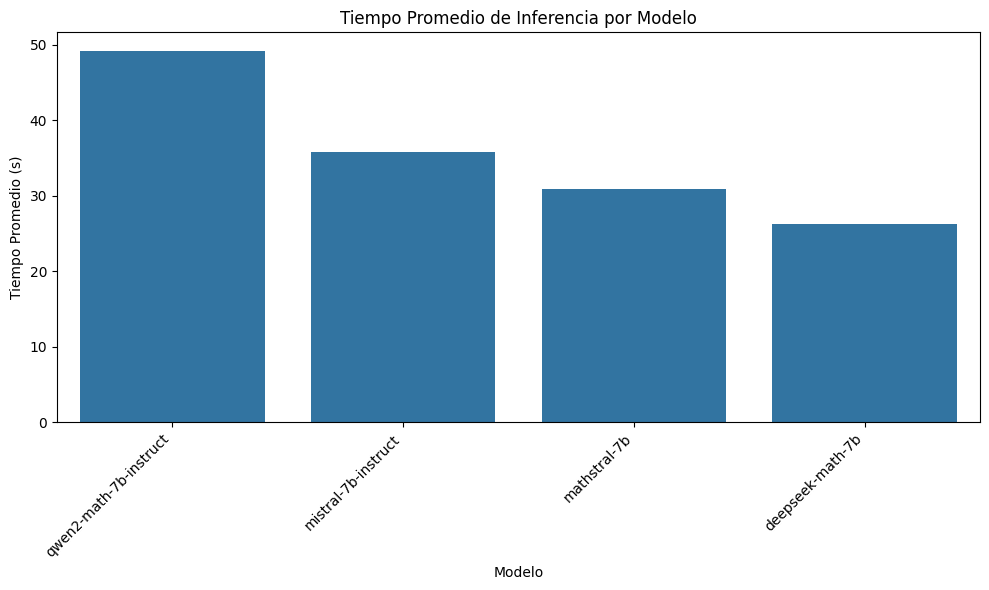

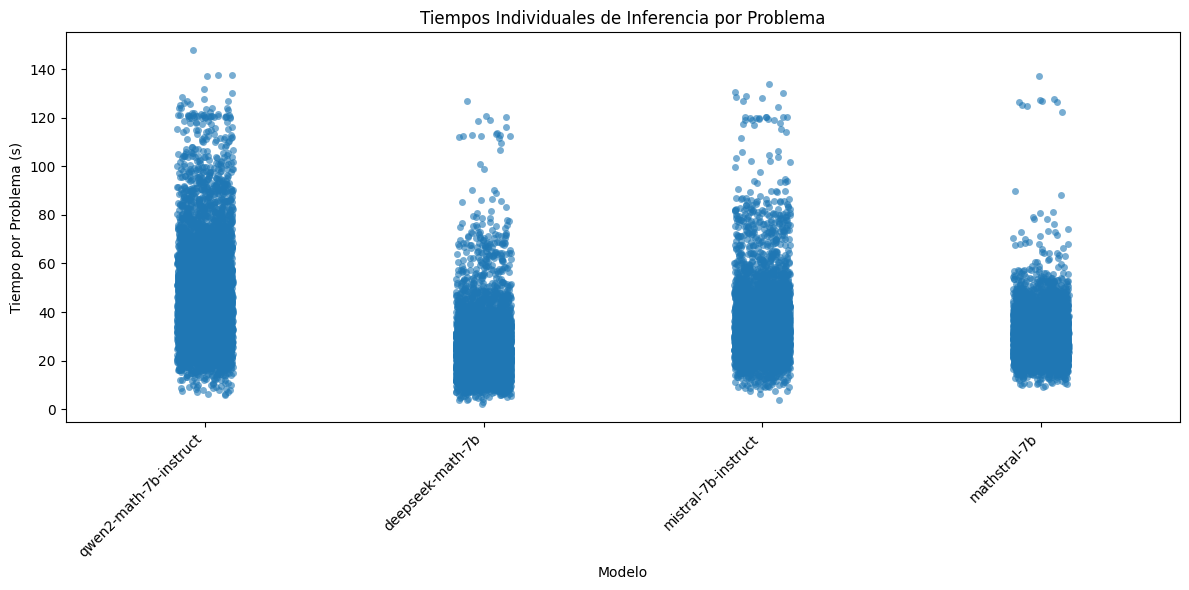

In [21]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"
all_dfs = []

# Cargar todos los CSV y añadir columna de modelo
for root, _, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
            df = pd.read_csv(os.path.join(root, file))
            df['model'] = df.get('model', ['unknown'])[0]
            all_dfs.append(df)

# Concatenar todos los DataFrames
full_df = pd.concat(all_dfs, ignore_index=True)

# Filtrar filas con tiempos válidos
valid_times_df = full_df.dropna(subset=["inference_time"])

# ── 1. Gráfico: Tiempo promedio de inferencia por modelo ──
model_times = valid_times_df.groupby('model')['inference_time'] \
                            .mean() \
                            .reset_index() \
                            .rename(columns={'model': 'Model', 'inference_time': 'Model Avg Time (s)'})
display(model_times)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=model_times,
    x="Model",
    y="Model Avg Time (s)",
    order=model_times.sort_values("Model Avg Time (s)", ascending=False)["Model"]
)
plt.title("Tiempo Promedio de Inferencia por Modelo")
plt.ylabel("Tiempo Promedio (s)")
plt.xlabel("Modelo")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# ── 2. Gráfico: Tiempo individual por problema ──
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=valid_times_df,
    x="model",
    y="inference_time",
    jitter=True,
    alpha=0.6
)
plt.title("Tiempos Individuales de Inferencia por Problema")
plt.ylabel("Tiempo por Problema (s)")
plt.xlabel("Modelo")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()





## 🕒 Tiempo Promedio de Inferencia por Modelo

| 🚀 Más rápido                          |
| -------------------------------------- |
| `deepseek-math-7b` → **26.25 s**       |
| `mathstral-7b` → **30.92 s**           |
| `mistral-7b-instruct` → **35.86 s**    |
| `qwen2-math-7b-instruct` → **49.22 s** |

### 💬 Análisis:

* **DeepSeek-Math-7B** es el modelo más eficiente en términos de velocidad. Esto lo hace especialmente atractivo para tareas donde el costo de cómputo o el tiempo de respuesta son críticos.
* **Qwen2-Math-7B-Instruct**, a pesar de su alta precisión, tiene un tiempo promedio de inferencia casi el doble que DeepSeek. Esto refleja su mayor carga computacional, probablemente debido a un pipeline de inferencia más complejo o prompts más largos.
* **Mathstral-7B** y **Mistral-7B-Instruct** se ubican en un rango medio, combinando precisión razonable con eficiencia aceptable.

---

### ⚖️ Consideraciones prácticas:

| Caso de uso                               | Modelo recomendado       | Justificación                          |
| ----------------------------------------- | ------------------------ | -------------------------------------- |
| **Alta velocidad**                        | `deepseek-math-7b`       | Menor tiempo promedio, buena ejecución |
| **Balance entre precisión y tiempo**      | `mathstral-7b`           | Intermedio en ambas métricas           |
| **Máxima precisión, sin importar tiempo** | `qwen2-math-7b-instruct` | Precisión destacada, pero más costoso  |




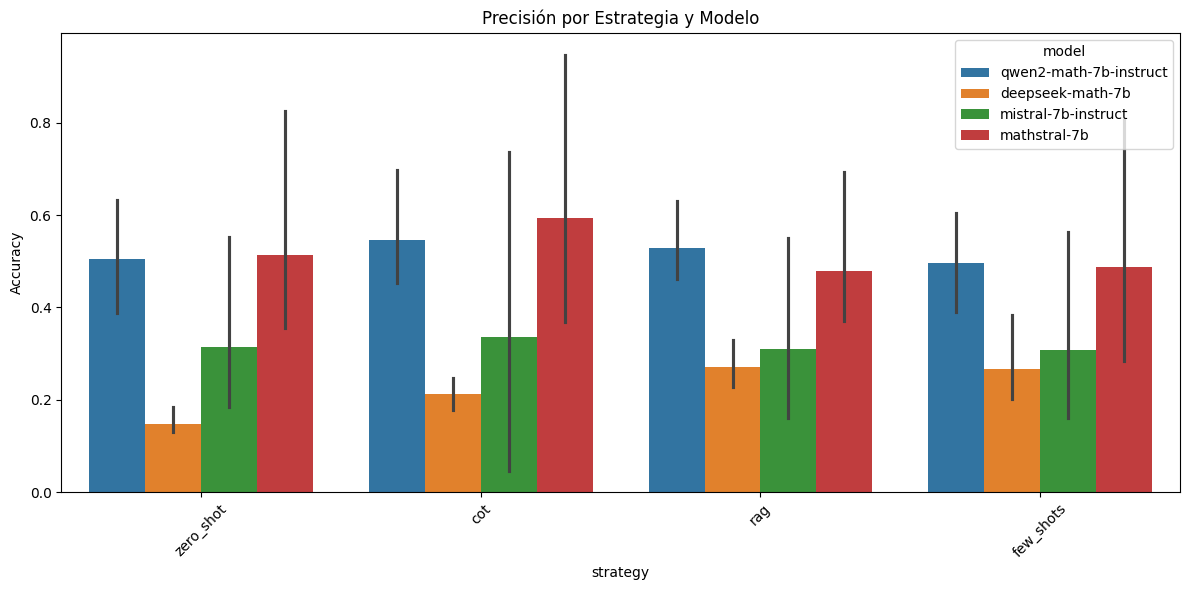

In [5]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# ─── 1. Configurar ruta base de resultados ───────────────────────────────
BASE_PATH = "/content/drive/MyDrive/tesis/resultados_consolidados"

# ─── 2. Recolectar métricas de todos los archivos CSV ────────────────────
summary = []
for root, dirs, files in os.walk(BASE_PATH):
    for file in files:
        if file.endswith(".csv"):
          path = os.path.join(root, file)
          try:
                df = pd.read_csv(path)
                if "is_correct" not in df.columns:
                    continue
                summary.append({
                    "model": df.get("model", ["unknown"])[0],
                    "strategy": df.get("strategy", ["unknown"])[0],
                    "dataset": df.get("dataset", ["unknown"])[0],
                    "total": len(df),
                    "correct": df["is_correct"].sum(),
                    "incorrect": (df["is_correct"] == False).sum(),
                    "accuracy": df["is_correct"].mean(),
                    "resolvable": df.get("is_octave_resolvable", pd.Series([None]*len(df))).sum(),
                    "inference_time_avg": df.get("inference_time", pd.Series([None]*len(df))).mean(),
                    "path": path
                })
          except Exception as e:
              print(f"⚠️ Error al procesar {path}: {e}")

summary_df = pd.DataFrame(summary)

# ─── 3. Guardar resumen en CSV ───────────────────────────────────────────
# resumen_path = os.path.join(BASE_PATH, "resumen_experimentos.csv")
# summary_df.to_csv(resumen_path, index=False)
# print(f"✅ Resumen guardado en: {resumen_path}")

# ─── 4. Visualizaciones ──────────────────────────────────────────────────
# Eliminar filas con datos faltantes
valid_df = summary_df.dropna(subset=["strategy", "model", "accuracy", "dataset"])

# Gráfico: Precisión por estrategia y modelo
plt.figure(figsize=(12, 6))
sns.barplot(data=valid_df, x="strategy", y="accuracy", hue="model")
plt.title("Precisión por Estrategia y Modelo")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

